In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
# mpl.use('Cairo')  # for saving SVGs that Affinity Designer can parse
import matplotlib.pyplot as plt
import seaborn as sns
import dill

import jax.numpy as jnp

import candas as can
import pathlib as pl

code_pth = pl.Path.cwd()  # for running in Jupyter
# code_pth = pl.Path(__file__)  # for running in terminal
fig_pth = code_pth.parent
data_pth = fig_pth / 'data'
graph_pth = fig_pth / 'graphics'    
graph_pth.mkdir(exist_ok=True)

gen_pth = fig_pth / 'generated'
gen_pth.mkdir(exist_ok=True)

plt.style.use(str(can.style.breve))

%config InlineBackend.figure_format = 'retina'

In [2]:
from utils import savefig

plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["lines.linewidth"] = 2

In [3]:
width = 3.45
height = 2.75 + 0.2
figsize = (width, height)
spotsize = 4**2
ticklabelsize = 5
labelsize = 6
linewidth = 1

palette = sns.diverging_palette(20, 220, as_cmap=True)

mar_l = 0.3
mar_r = 0.3
mar_t = 0.22
mar_b = 0.275 + 0.2
ax_space = 0.075


def format_sns_axes(fig, axs, axes_dict, xticks, xlim, ylim=None, width=width, height=height, mar_b=mar_b, mar_l=mar_l, mar_r=mar_r, mar_t=mar_t, ax_space=ax_space):
    fig.set_size_inches((width, height))

    ylim = ylim or [-1.1, 1.1]

    plt.setp(
        axs,
        ylim=ylim,
        yticks=[-1, -0.5, 0, 0.5, 1],
        xticks=xticks,
        xlim=xlim,
        title="",
    )
    for i, ax in enumerate(axs.flat):
        ax.tick_params(axis="both", labelsize=ticklabelsize, length=1, width=0.6)
        ax.set_ylabel(ax.get_ylabel(), fontsize=labelsize, labelpad=0)
        ax.set_xlabel(ax.get_xlabel(), fontsize=labelsize, labelpad=2)
        # if i > 0:
        #     ax.yaxis.set_tick_params(length=0)
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

    for (row, col), ax in axes_dict.items():
        ax.set_title("")

        if col == 8.0:
            ax2 = ax.twinx()
            ax2.set_yticks([])
            ax2.set_ylabel(
                f"{row:.1f}", va="bottom", fontsize=labelsize, rotation=270, labelpad=1
            )
            if row == 5.0:
                ax2.set_ylabel(
                    f"log$_{1}$$_{0}$ Copies Competitor 2\n{row:.1f}",
                    va="bottom",
                    fontsize=labelsize,
                    rotation=270,
                    labelpad=1,
                )

        if row == 8.0:
            ax.set_title(f"{col:.1f}", fontsize=labelsize, pad=2)
            if col == 5.0:
                ax.set_title(
                    f"log$_{1}$$_{0}$ Copies Competitor 1\n{col:.1f}",
                    fontsize=labelsize,
                    pad=2,
                )

        if ax != axs[-1, 0]:
            ax.set_xlabel("")
            ax.set_ylabel("")

    bbox = ax.get_window_extent().transformed(ax.figure.dpi_scale_trans.inverted())
    ax_width, ax_height = bbox.width, bbox.height

    plt.subplots_adjust(
        left=mar_l / width,
        right=1 - mar_r / width,
        top=1 - mar_t / height,
        bottom=mar_b / height,
        wspace=ax_space / ax_width,
        hspace=ax_space / ax_height,
    )

In [4]:
target = np.array([[-1, +1]])
competitor = np.array([[-1, +1]])

positive_labels = np.array([[1, 0, 0, 0], [0, 0, 1, 0]])

rxn_b = can.models.CAN(
    target,
    competitor,
    positive_labels,
    INT_names=["WT"],
    EXT_names=["REF"],
    label_names=["H", "F"],
)

rxn_b.n_cycles = 50
rxn_b.compile()


def sym_bipartite(
    ref_rate,
    ref_lgQ,
    wt_rate=0.9,
    wt_start=2,
    wt_end=8,
    n_points=100,
    ref_drift=0,
    wt_drift=0,
):

    rxn_b.oligo("WT").rate = wt_rate
    rxn_b.oligo("REF").rate = ref_rate

    rxn_b.oligo("WT").drift = wt_drift
    rxn_b.oligo("REF").drift = ref_drift

    rxn_b.oligo("REF").copies = 10**ref_lgQ

    wt_lgQ = np.linspace(wt_start, wt_end, n_points)

    arrays = [wt_lgQ]
    grids = jnp.meshgrid(*arrays)
    pts = jnp.vstack([grid.ravel() for grid in grids]).T

    rxn_b.sweep_setup = arrays, grids, pts, rxn_b.INT_idxs
    sol = rxn_b.solution_sweep()
    return wt_lgQ, sol


Saving fig_S10A__immense_sardine in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


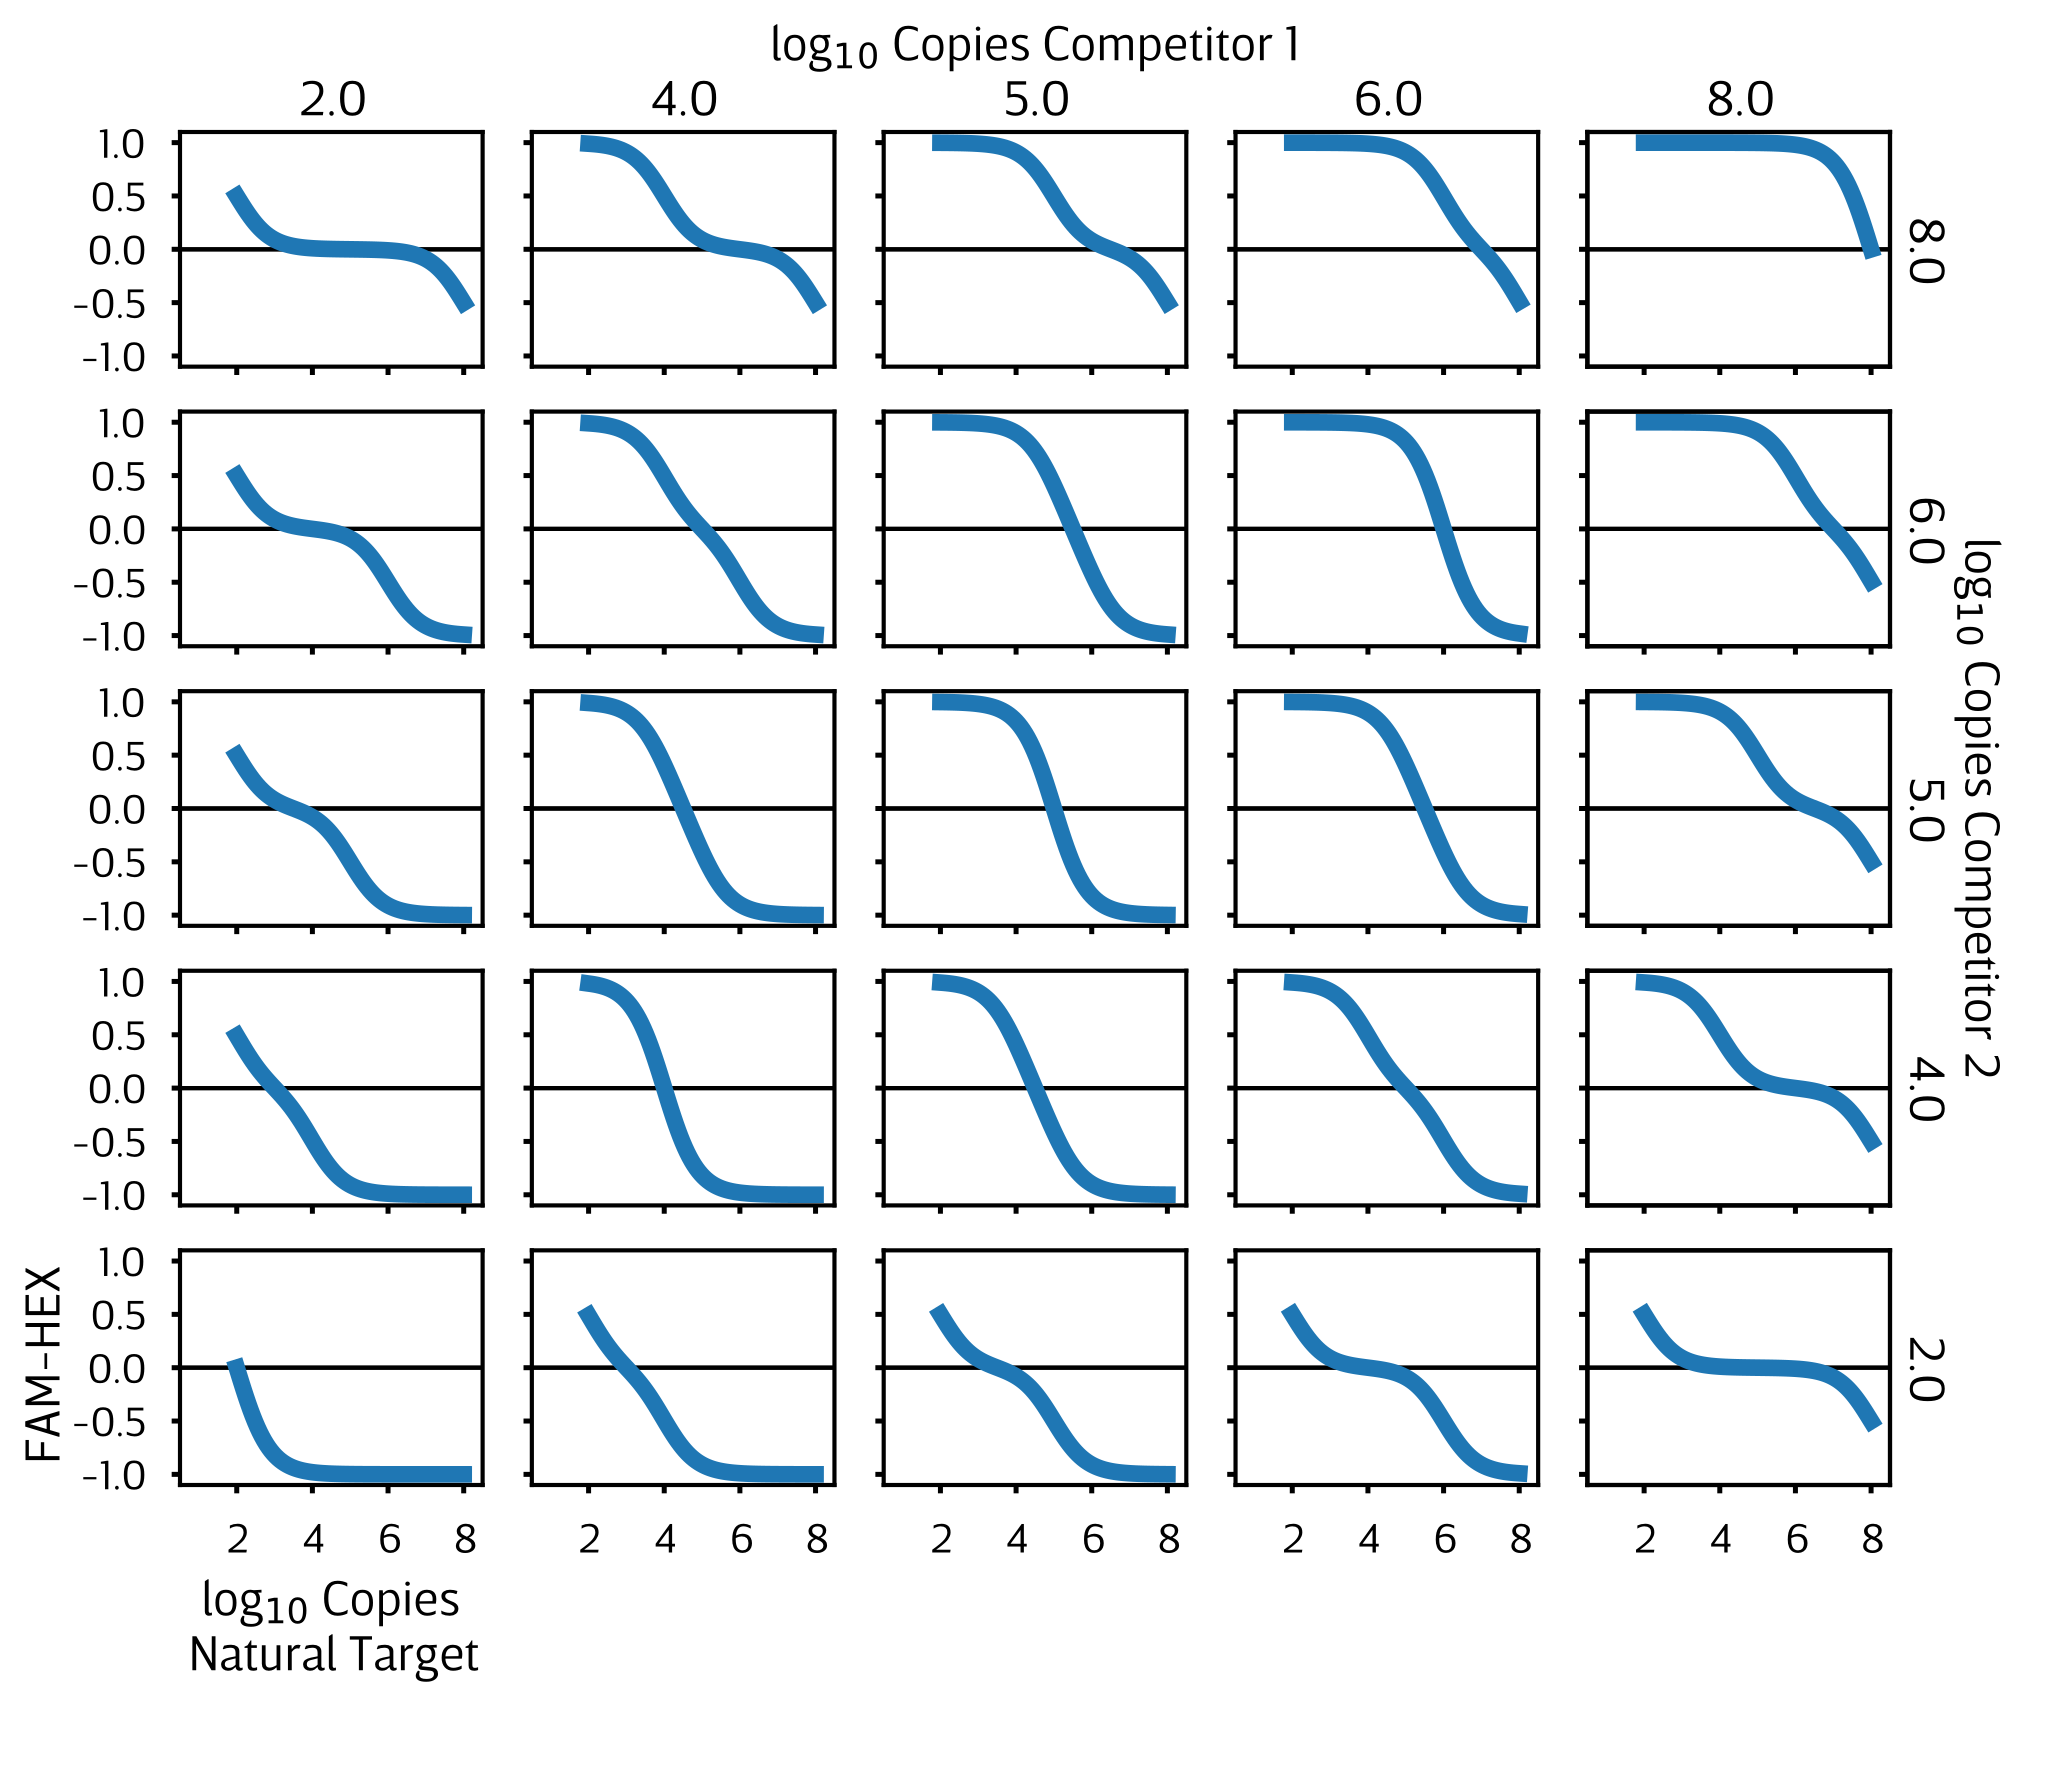

In [5]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=ref1_lgQ,
            wt_rate=1.0,
        )
        wt_lgQ, sol2 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=ref2_lgQ,
            wt_rate=1.0,
        )
        ax.plot(wt_lgQ, -(sol1+sol2)/2)
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="immense_sardine")

Saving fig_S10B__spicy_xantus in /home/john/projects/can-manuscript/fig_S10__cold_mole/graphics: [.svg] [.png] done


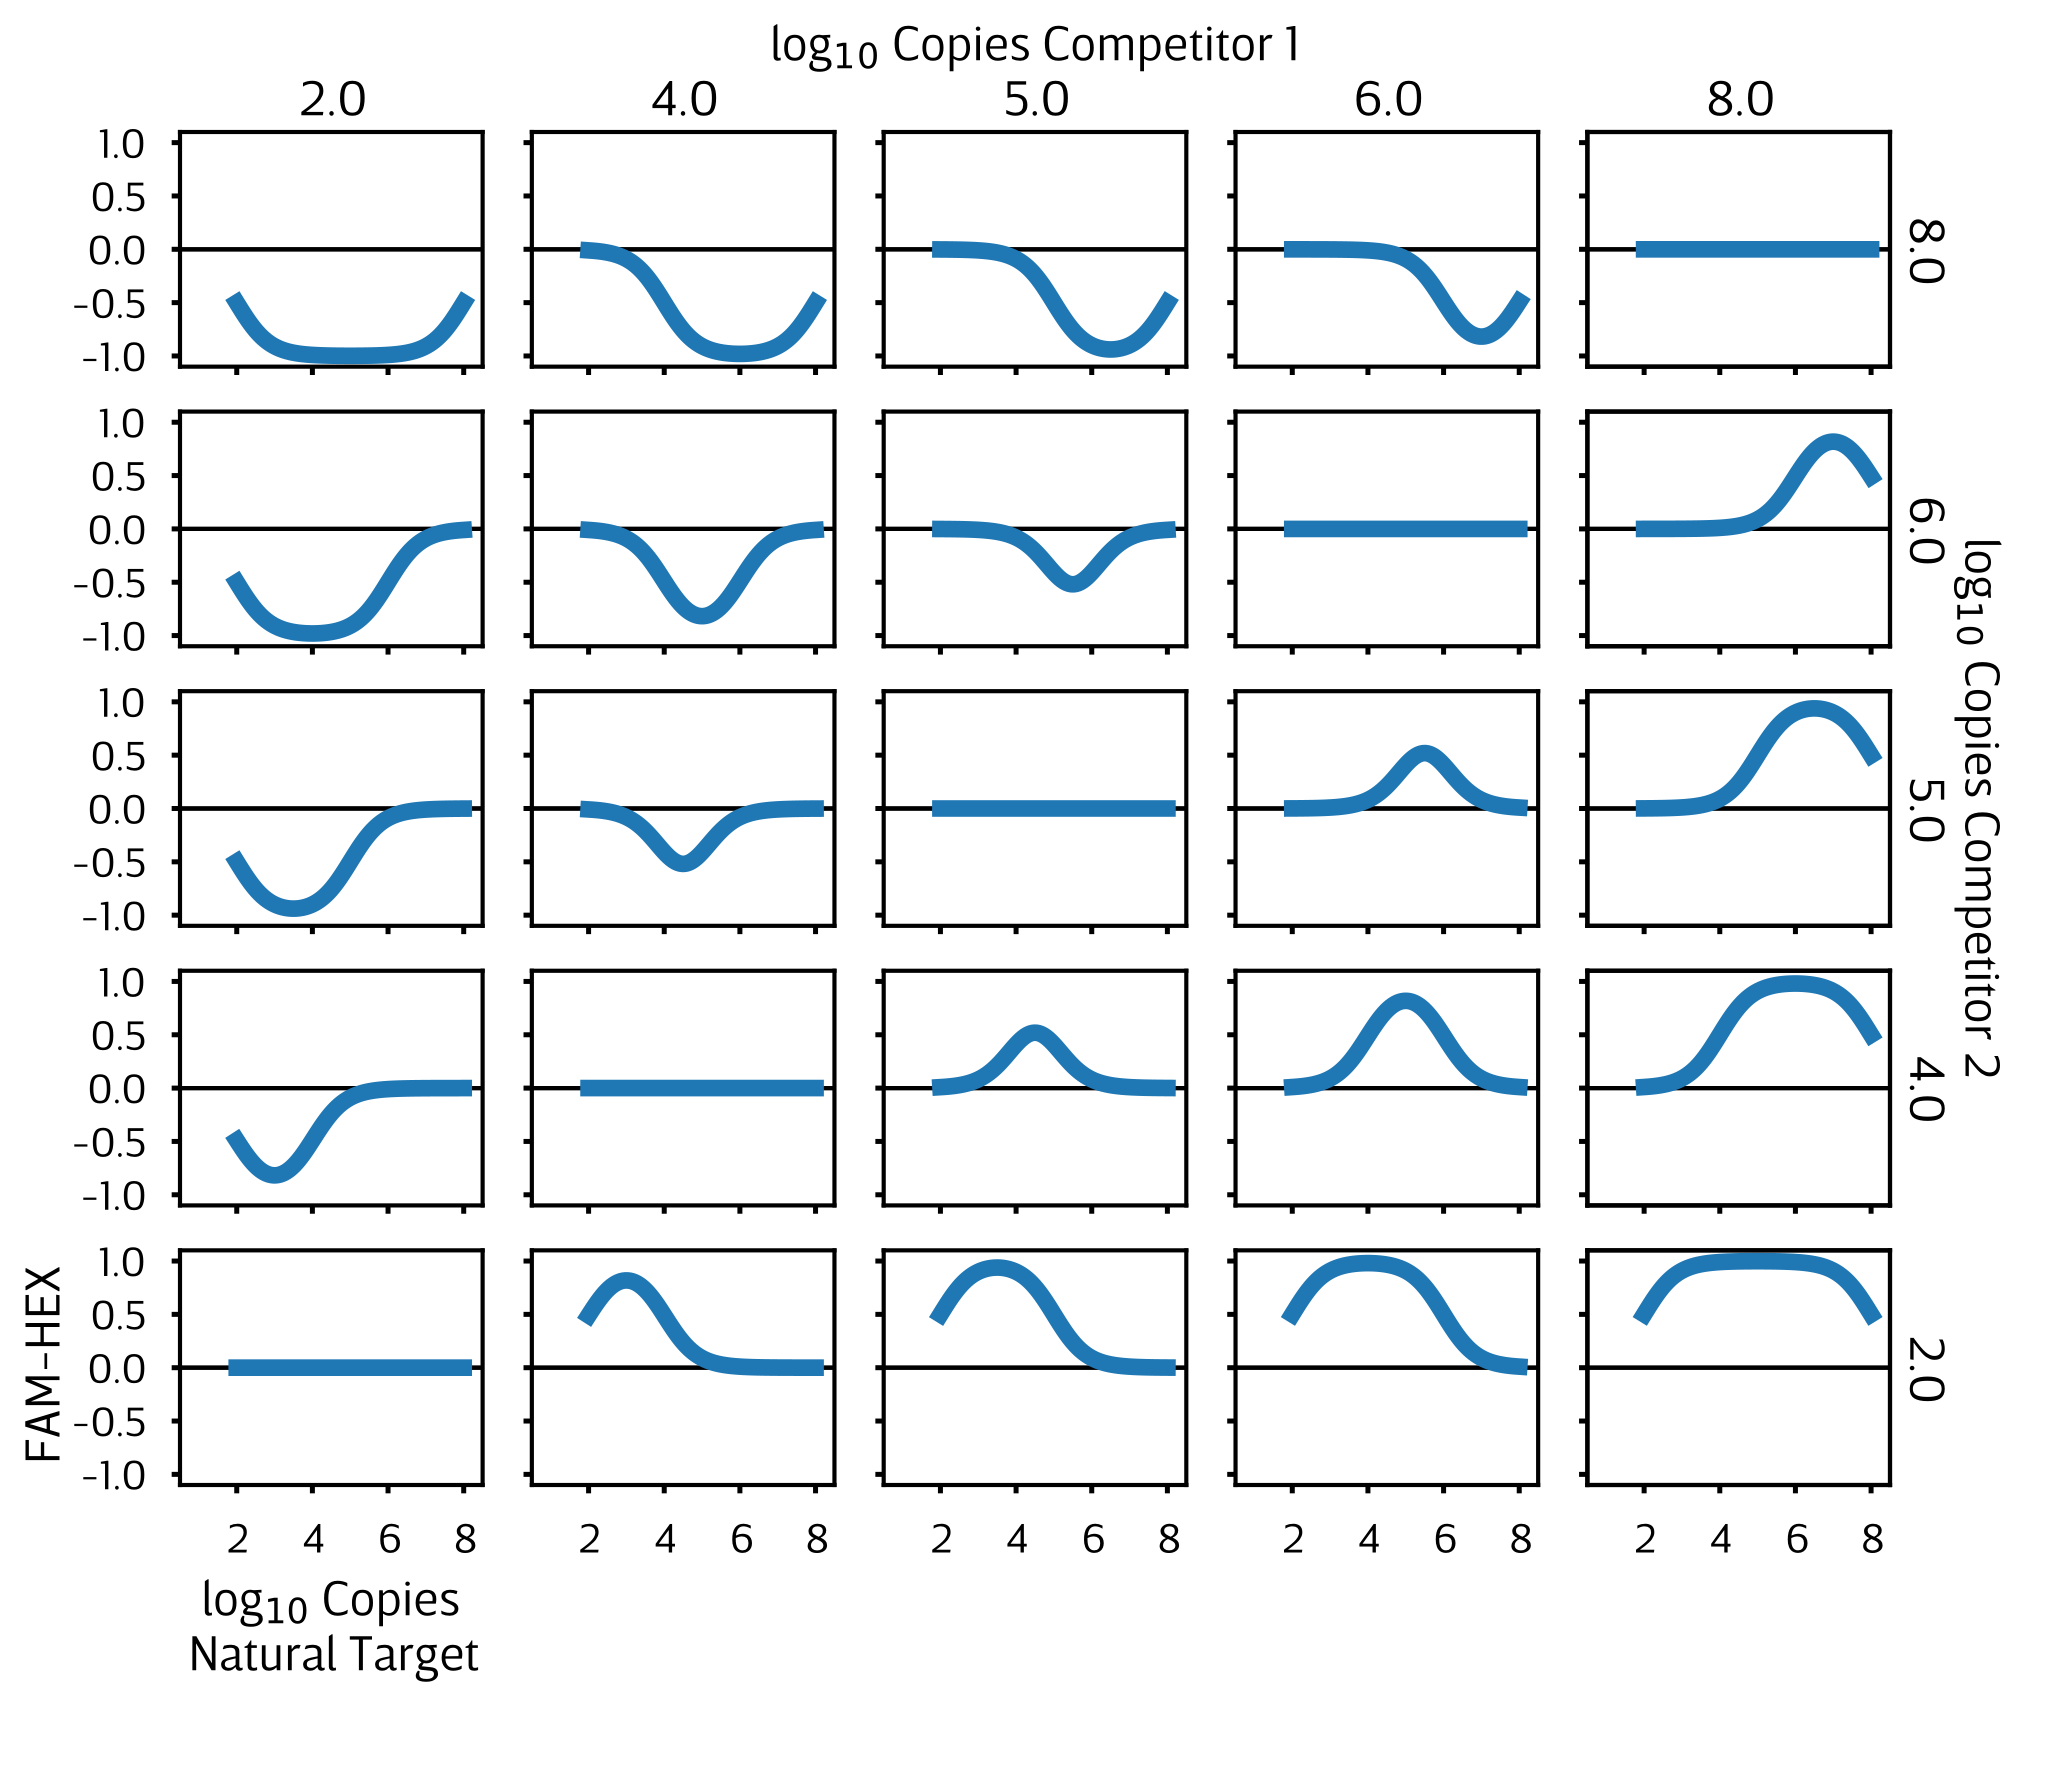

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_dict = {
    (row, col): axs[i, j]
    for i, row in enumerate([2, 4, 5, 6, 8][::-1])
    for j, col in enumerate([2, 4, 5, 6, 8])
}

for (ref2_lgQ, ref1_lgQ), ax in axes_dict.items():
        wt_lgQ, sol1 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=ref1_lgQ,
            wt_rate=1.0,
        )
        wt_lgQ, sol2 = sym_bipartite(
            ref_rate=1.0,
            ref_lgQ=ref2_lgQ,
            wt_rate=1.0,
        )
        ax.plot(wt_lgQ, -(sol1-sol2)/2)
        
        ax.axhline(0, color="k", linestyle="-", linewidth=0.5, zorder=-1)

format_sns_axes(fig, axs, axes_dict, xticks=[2, 4, 6, 8], xlim=[0.5, 8.5])
axs[-1, 0].set_xlabel(r"log$_{10}$ Copies"+"\nNatural Target", fontsize=labelsize, labelpad=2)
axs[-1, 0].set_ylabel("FAM-HEX", fontsize=labelsize)

savefig(plt.gcf(), alias="spicy_xantus")